In [1]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install scikit-cuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np

In [4]:
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import pycuda.cumath
import pycuda.curandom
from pycuda.compiler import SourceModule

In [5]:
from skcuda import fft

/usr/local/lib/python3.7/dist-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [6]:
###################
# iDivUp FUNCTION #
###################
def iDivUp(a, b):
    # Round a / b to nearest higher integer value
    a = np.int32(a)
    b = np.int32(b)
    return (a / b + 1) if (a % b != 0) else (a / b)

In [7]:
mod = SourceModule("""
   
   #include <pycuda-complex.hpp>

   typedef pycuda::complex<float> cmplx;
   
   __global__ void projectionKernel(const float * __restrict__ d_measuredAmplitude, cmplx * __restrict__ d_current, const int M, const int N) {

	    const int tidx = threadIdx.x + blockIdx.x * blockDim.x;
	    const int tidy = threadIdx.y + blockIdx.y * blockDim.y;

	    if ((tidy >= M) || (tidx >= N)) return;
	    
      float d_scaling = d_measuredAmplitude[tidy * N + tidx] / (abs(d_current[tidy * N + tidx]) + 1e-7);
      
      d_current[tidy * N + tidx]	= d_scaling * d_current[tidy * N + tidx];
       
    }
  
  """)

In [8]:
projection = mod.get_function("projectionKernel")

In [9]:
def GS_Python_PyCUDA(d_img, maxIter):
    
    d_img = d_img.astype(np.complex64)

    height, width = d_img.shape
    
    # --- Assumptions
    d_measuredAmplitudeSpace    = pycuda.cumath.sqrt(d_img)
    d_measuredAmplitudeFourier  = pycuda.gpuarray.ones_like(d_measuredAmplitudeSpace, dtype = np.complex64)
    
    # --- Starting point
    rg                          = pycuda.curandom.XORWOWRandomNumberGenerator()
    d_currentPhaseSpace         = rg.gen_normal((height, width), dtype = np.float32) + 1j * rg.gen_normal((height, width), dtype = np.float32)
    
    # --- Initialization
    d_currentPhaseFourier       = pycuda.gpuarray.ones_like(d_measuredAmplitudeSpace)
    d_currentFourier            = pycuda.gpuarray.empty_like(d_measuredAmplitudeSpace)

    d_currentSpace              = d_measuredAmplitudeSpace * pycuda.cumath.exp(1j * d_currentPhaseSpace)

    plan                        = fft.Plan(d_currentSpace.shape, np.complex64, np.complex64)
    
    for iter in range(maxIter):
        # --- Enforce measured amplitude constraint in the Fourier domain
        fft.fft(d_currentSpace, d_currentFourier, plan)
        d_currentFourier            = d_measuredAmplitudeFourier * d_currentFourier / (d_currentFourier.__abs__() + 1e-7)

        # --- Enforce measured amplitude constraint in the spatial domain
        fft.ifft(d_currentFourier, d_currentSpace, plan)
        d_currentSpace              = d_measuredAmplitudeSpace * d_currentSpace / (d_currentSpace.__abs__() + 1e-7)

    currentSpace = d_currentSpace.get()

    return currentSpace

In [10]:
def GS_Python_PyCUDA_kernel(d_img, maxIter):
    
    BLOCKSIZEX = 16
    BLOCKSIZEY = 16

    height, width = d_img.shape

    blockDim    = (BLOCKSIZEX, BLOCKSIZEY, 1)
    gridDim     = (int(iDivUp(width, BLOCKSIZEX)), int(iDivUp(height, BLOCKSIZEY)), 1)
    
    # --- Assumptions
    d_measuredAmplitudeSpace    = pycuda.cumath.sqrt(d_img)
    d_measuredAmplitudeFourier  = pycuda.gpuarray.ones_like(d_measuredAmplitudeSpace, dtype = np.float32)
    
    # --- Starting point
    rg                          = pycuda.curandom.XORWOWRandomNumberGenerator()
    d_currentPhaseSpace         = rg.gen_normal((height, width), dtype = np.float32) + 1j * rg.gen_normal((height, width), dtype = np.float32)
    
    # --- Initialization
    d_currentPhaseFourier       = pycuda.gpuarray.ones_like(d_measuredAmplitudeSpace)
    d_currentFourier            = pycuda.gpuarray.empty_like(d_measuredAmplitudeSpace)

    d_currentSpace              = d_measuredAmplitudeSpace * pycuda.cumath.exp(1j * d_currentPhaseSpace)

    plan                        = fft.Plan(d_currentSpace.shape, np.complex64, np.complex64)
    
    for iter in range(maxIter):
        # --- Enforce measured amplitude constraint in the Fourier domain
        fft.fft(d_currentSpace, d_currentFourier, plan)
        projection(d_measuredAmplitudeFourier, d_currentFourier, np.int32(height), np.int32(width), block = blockDim, grid = gridDim)

        # --- Enforce measured amplitude constraint in the spatial domain
        fft.ifft(d_currentFourier, d_currentSpace, plan)
        projection(d_measuredAmplitudeSpace, d_currentSpace, np.int32(height), np.int32(width), block = blockDim, grid = gridDim)

    currentSpace = d_currentSpace.get()

    return currentSpace

Main program.

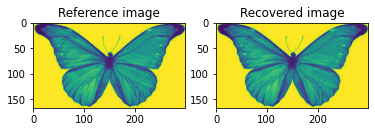

In [11]:
filename = 'butterfly.jfif'
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float32)

# --- Maximum number of iterations
maxIters = 1000

d_img = pycuda.gpuarray.to_gpu(img)

#currentSpace = GS_Python_PyCUDA(d_img, maxIters)
currentSpace = GS_Python_PyCUDA_kernel(d_img, maxIters)

plt.figure(1)

# --- Reference image
plt.subplot(121)
plt.imshow(img.astype(np.float32))
plt.title('Reference image')

plt.subplot(122)
plt.imshow((currentSpace.__abs__())**2)
plt.title('Recovered image')

plt.show()

In [12]:
print(type(img))

<class 'numpy.ndarray'>
